# Optimization Methods Project Work: SMO and DCD-Linear for training SVM

This notebook will contain some code that implements the SMO and DCD-Linear algorithm, plus the results.

## Testing the environment

The following cell will simply verify if all the libraries necessary to run the code are correctly installed.

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math
import random
import time
import os
import json
import pandas as pd
from numpy.linalg import norm
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import dump_svmlight_file
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

random.seed(91212) # This function allows to replicate the same experiemtns even if the random function is used

print("Everything is good!")

Everything is good!


In [2]:
def load_dataset(name: str, dimension = None, features = None):
    bias = load_svmlight_file(name)
    bias = (bias[0].toarray(), bias[1])

    if(dimension is not None):
        permutation = np.random.permutation(bias[0].shape[0])

        indexs = permutation[0:dimension]
        bias = (bias[0][indexs], bias[1][indexs])

    if features is not None:
        bias = (bias[0][:, features], bias[1])
    
    new_column = np.atleast_2d(np.ones(bias[0].shape[0])).T
    unbias = (np.hstack([bias[0], new_column]), bias[1])

    return (bias, unbias)
    
def feature_extractor(feature_num: int, original_num: int):
    permutation = np.random.permutation(original_num)
    return np.sort(permutation[0:feature_num])

## Defining the Dual Problem

### The Bias One (For SMO)

As we know, the formulation of the dual problem for training a SVM is:
$$
\begin{gather*}
\min_{\alpha} \frac{1}{2}\alpha^TQ\alpha - e^T\alpha \\
\forall i\ 0 \leq \alpha_i \leq C\ \ \sum \limits_i^n \alpha_iy_i = 0
\end{gather*}
$$

As stated in the Project Goals, we will use the Most Violating Pair rule to select the variables to change. So, to implement this algorithm efficiently, we need those elements:
* A function that calculates the derivatives
* A function that adjust the derivative after changing $\alpha$ 
* A function that extract the most violating pair.

To sum up all this functionality, they will be implemented inside a class. The constructor will receive the set of Xs and Ys, and using that will derive Q.

In [3]:
class DualSVMProblem:

    def __init__(self, Xs, Ys, C, epsilon = 1e-5, sparse = False):
        self.X = Xs
        self.Y = Ys
        self.C = C
        self.a = np.zeros_like(Ys, dtype = float)
        self.e = np.ones_like(self.a)
        self.epsilon = epsilon
        self.sparse = sparse

        if sparse:
            self.calculated = [False] * self.Y.shape[0]
            self.Q = {}
        else:
            mat = np.stack([Ys.T] * Xs.shape[1], axis = 1)
            
            Z = Xs * mat
            self.Q = Z @ Z.T
        
        self.d = - self.e

    def getA(self):
        return self.a
        
    def getDerivative(self):
        return self.d    

    def getMostViolatingPair(self):
        
        directions = self.d / self.Y
        min_idx = -1
        min_value = np.inf
        max_idx = -1
        max_value = -np.inf
        
        R = directions.copy()
        R[np.logical_and(self.a < self.epsilon, self.Y == -1)] = np.inf
        R[np.logical_and(self.a > (self.C - self.epsilon), self.Y == 1)] = np.inf

        S = directions.copy()
        S[np.logical_and(self.a < self.epsilon, self.Y == 1)] = -np.inf
        S[np.logical_and(self.a > (self.C - self.epsilon), self.Y == -1)] = -np.inf

        min_idx = np.argmin(R)
        max_idx = np.argmax(S)

        if R[min_idx] == np.inf or S[max_idx] == -np.inf:
            return None
                
        return (min_idx, max_idx)

    def updateA(self, idx1, a1, idx2, a2):

        if self.sparse:
            self.d = self.getQColumn(idx1) * (a1 - self.a[idx1]) + self.getQColumn(idx2) * (a2 - self.a[idx2]) + self.d
        else:
            self.d = self.Q[idx1] * (a1 - self.a[idx1]) + self.Q[idx2] * (a2 - self.a[idx2]) + self.d
        
        self.a[idx1] = a1
        self.a[idx2] = a2

    def getParameters(self):
        mat = np.stack([self.a.T * self.Y.T] * self.X.shape[1], axis = 1)
        w = np.sum(mat * self.X, axis = 0)
        b = 0
        for i in range(len(self.a)):
            if(self.a[i] < self.epsilon or self.a[i] > self.C - self.epsilon):
                continue
            b = 1 / self.Y[i] - w @ self.X[i]
            break        
        return (w, b)

    def getQColumn(self, i):
        if self.sparse:
            if not self.calculated[i]:
                self.Q[i] = self.Y[i] * (self.Y * (self.X @ self.X[i]))
                self.calculated[i] = True
        return self.Q[i]
        

class SVM:
    def __init__(self, w, b):
        self.w = w
        self.b = b

    def __call__(self, x):
        return np.sign(x @ self.w + self.b)

def dual_loss_svm(a, Q):
    return 0.5 * (a.T @ Q @ a) - np.sum(a)

def loss_svm_obj(svm, C, X, y):
    return loss_svm(svm.w, svm.b, C, X, y)
    
def loss_svm(w, b, C, X, y):
    psi = np.maximum(np.zeros_like(y), np.ones_like(y) - y * (X @ w + np.ones_like(y) * b))
    return 0.5 * (w.T @ w) + C * np.sum(psi)

In [4]:
# Let's test the code with some artificial data
X = np.array([[1, 2, 3], [4, 5, 6]])
Y = np.array([1, -1])
C = 5

# The safe way to calculate matrix Q
Q = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        Q[i][j] = Y[i] * Y[j] * X[i] @ X[j]

problem = DualSVMProblem(X, Y, C)

ok = True
    
if ((np.array([-1, -1]) != problem.getDerivative()).all()):
    ok = False
    print("The derivative function if wrong")

update = np.array([1, 2])
problem.updateA(0, update[0], 1, update[1])

if (norm(Q[0] - problem.getQColumn(0)) > 1e-3 or norm(Q[1] - problem.getQColumn(1)) > 1e-3):
    ok = False
    print("The matix calculation is wrong")
    
if ((Q @ update - np.ones(2) != problem.getDerivative()).all()):
    ok = False
    print("The updates of variables doesn't update the derivative in the right way")

elements = problem.getDerivative() / Y

if not (problem.getMostViolatingPair()[0] == (0 if elements[0] < elements[1] else 1) and problem.getMostViolatingPair()[1] == (0 if elements[0] > elements[1] else 1)):
    ok = False
    print("The calculation of the most violating pair is wrong")
    # This test is a bit odd and not exaustive, but can help

if ok:
    print("Everything is working as expected!")

Everything is working as expected!


## Implementation of SMO

After implementing core elements for the SMO algorithm, it's time to get them together and build the actual result.
In this implementation, I realized a function that execute a single iteration of the algorithm, leaving the check of convergence outside. The objective is to reuse the external function with the different approach (DCD-Linear), and then make easier to instrument the code to measure some components like loss, validation, etc.

In [5]:
from typing import Callable
def trainingSMO(problem: DualSVMProblem, step: Callable[[DualSVMProblem], bool], loss_func: Callable[[None], float] = None, validation_func: Callable[[None], float] = None, epsilon = 1e-5, verbose = False):
    loss = []
    validation = []
    
    while(True): 
        (min_idx, max_idx) = problem.getMostViolatingPair()
        elements = problem.getDerivative() / problem.Y

        if verbose:
            print(f"Stopping condition: {elements[max_idx] - elements[min_idx]}")
        if(elements[min_idx] + epsilon > elements[max_idx]):
            break
        
        result = step(problem)            
        (w, b) = problem.getParameters()
        svm = SVM(w, b)
        
        if(loss_func is not None):
            loss.append(loss_func())
    
        if(validation_func is not None):
            validation.append(validation_func())

        if not result:
            # If the step method give False as a result indicates an error or a stop condition (i.e. having a derivative under the tollerance)
            break

    return (loss, validation)

def SMO_step(problem: DualSVMProblem, epsilon: float = 1e-5):
    test = problem.getMostViolatingPair()
    if(test is None):
        raise Exception("The problem did not give a valid violating pair")
    (min_idx, max_idx) = (test[0], test[1])

    direction = np.zeros_like(problem.a)
    direction[min_idx] = 1 * problem.Y[min_idx]
    direction[max_idx] = - 1 * problem.Y[max_idx] #In theory I should divide, but y is in {-1, 1} making the multiplication equivalent, but more efficient

    derivative = problem.getDerivative()

    b = problem.C - problem.a[min_idx] if direction[min_idx] > 0 else problem.a[min_idx]
    b = min(b, problem.C - problem.a[max_idx] if direction[max_idx] > 0 else problem.a[max_idx])
    
    if b < epsilon:
        return False

    tmp = problem.getQColumn(min_idx) * problem.Y[min_idx] - problem.getQColumn(max_idx) * problem.Y[max_idx]   
    value = direction.T @ tmp

    if value > epsilon:
        b = min(b, -(derivative.T @ direction) / value)

    problem.updateA(min_idx, problem.a[min_idx] + b * direction[min_idx], max_idx, problem.a[max_idx] + b * direction[max_idx])
    return True    

## Testing the Code

In the following cells, I will use a very simple classification problem to see if the code works at all. [This dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#breast-cancer) is composed by only 683 elements, everyone of only 10 features. This dataset is chosen dues to it contained dimension. In fact, this implementation of the Dual SVM explicitly calculate the Q matrix, something that can become prohibitive very quickly in the increase of elements.

In [6]:
(Xs, Ys) = load_svmlight_file("datasets/covtype_scale")
Ys[Ys == 2] = -1

Xs = Xs.toarray()

dump_svmlight_file(Xs, Ys, "datasets/covtype_ones")

In [7]:
(Xs, Ys) = load_svmlight_file("datasets/breast_cancer_scale")
Ys[Ys == 2] = 1
Ys[Ys == 4] = -1 # TODO control the description to decide what is positive and what is negative

Xs = Xs.toarray()

dump_svmlight_file(Xs, Ys, "datasets/breast_cancer_ones")

# There is a lot to say (Xs originally is a sparce matrix, not scaled values broke the model, Ys classes are 2 and 4)

In [51]:
(train_Xs, test_Xs, train_Ys, test_Ys)  = train_test_split(Xs, Ys, test_size = 0.20)

base_svm = LinearSVC(C = 10)
base_svm.fit(train_Xs, train_Ys)

train_preds = base_svm.predict(train_Xs)
test_preds = base_svm.predict(test_Xs)


print("Report on train set:")
print(classification_report(train_Ys, train_preds, zero_division = 0))

print("Report on test set:")
print(classification_report(test_Ys, test_preds, zero_division = 0))

Report on train set:
              precision    recall  f1-score   support

        -1.0       0.96      0.96      0.96       188
         1.0       0.98      0.98      0.98       358

    accuracy                           0.97       546
   macro avg       0.97      0.97      0.97       546
weighted avg       0.97      0.97      0.97       546

Report on test set:
              precision    recall  f1-score   support

        -1.0       0.94      0.98      0.96        51
         1.0       0.99      0.97      0.98        86

    accuracy                           0.97       137
   macro avg       0.97      0.97      0.97       137
weighted avg       0.97      0.97      0.97       137



In [52]:
base_smo_problem = DualSVMProblem(train_Xs, train_Ys, C = 10)

(_, _) = trainingSMO(base_smo_problem, SMO_step, epsilon = 1e-2)

(w, b) = base_smo_problem.getParameters()
smo_svm = SVM(w, b)
smo_train_preds = smo_svm(train_Xs)
smo_test_preds = smo_svm(test_Xs)

print("Result of the model trained using SMO on training set:")
print(classification_report(train_Ys, smo_train_preds, zero_division=0))

print("Result of the model trained using SMO on test set:")
print(classification_report(test_Ys, smo_test_preds, zero_division=0))

Result of the model trained using SMO on training set:
              precision    recall  f1-score   support

        -1.0       0.95      0.97      0.96       188
         1.0       0.98      0.97      0.98       358

    accuracy                           0.97       546
   macro avg       0.97      0.97      0.97       546
weighted avg       0.97      0.97      0.97       546

Result of the model trained using SMO on test set:
              precision    recall  f1-score   support

        -1.0       0.94      1.00      0.97        51
         1.0       1.00      0.97      0.98        86

    accuracy                           0.98       137
   macro avg       0.97      0.98      0.98       137
weighted avg       0.98      0.98      0.98       137



In [55]:
print(f"Difference in norm of w: {norm(w - base_svm.coef_)}")
print(f'"Correlation" between the direction of ws : {(w.T @ base_svm.coef_[0]) / (norm(w) * norm(base_svm.coef_[0]))}')
print(f"Difference in the value b: {abs(b - base_svm.intercept_)}")

Difference in norm of w: 1.3349417829513692
"Correlation" between the direction of ws : 0.7556330914500424
Difference in the value b: [1.97524854]


## Verifying if the sparse implementation gives some benefits

In [11]:
(A, B) = load_dataset("datasets/covtype_ones", dimension = 5000)

start_time = time.time()
unsparse_smo_problem = DualSVMProblem(A[0], A[1], C = 1)
(_, _) = trainingSMO(unsparse_smo_problem, SMO_step, epsilon = 1e-2)
time_taken = time.time() - start_time
print(f"Time Taken by the base method: {time_taken}")

Time Taken by the base method: 12.866105556488037


In [12]:
start_time = time.time()
sparse_smo_problem = DualSVMProblem(A[0], A[1], C = 1, sparse = True)
(_, _) = trainingSMO(sparse_smo_problem, SMO_step, epsilon = 1e-2)
time_taken = time.time() - start_time
print(f"Time Taken by the sparce method: {time_taken}")

Time Taken by the sparce method: 14.308423042297363


## DCD Linear

After implementing the SMO algorithm, now it's time to implement the DCD version. To maintain the uniformity in the problem definition, I will implement the dual formulation of the L1-SVM problem. 

In [14]:
class DCDDualProblem:

    def __init__(self, Xs, Ys, C, epsilon = 1e-5):
        self.X = Xs
        self.Y = Ys
        self.C = C
        self.a = np.zeros_like(Ys, dtype = float)
        self.e = np.ones_like(Ys)
        self.diagQ = np.pow(np.sum(np.pow(Xs, 2), axis = 1, dtype = float), -1) #Inverse Diagonal of Q

        self.w = np.zeros(Xs.shape[1], dtype = float)

        self.epsilon = epsilon

    def optimizeOver(self, index):
        G = self.Y[index] * self.w.T @ self.X[index] - 1

        if self.a[index] < self.epsilon:
            PG = min(G, 0)
        elif self.a[index] > self.C - self.epsilon:
            PG = max(G, 0)
        else:
            PG = G

        if abs(PG) < self.epsilon:
            return

        new_a = min(max(self.a[index] - G * self.diagQ[index], 0), self.C) #Notice that during initialization of the class diagQ is already inverted. In this way the code should be more efficient
        self.w = self.w + (new_a - self.a[index]) * self.Y[index] * self.X[index]
        self.a[index] = new_a

    def getDerivativeElement(self, i):
        return self.Y[i] * self.w.T @ self.X[i] - 1

    def shrunkenCondition(self, i, M, m):
        if self.a[i] < self.epsilon and self.getDerivativeElement(i) > M:
            return True
        if self.a[i] > self.C - self.epsilon and self.getDerivativeElement(i) < m:
            return True
        return False
        
    def getProjectedDerivative(self):        
        derivative = self.Y * (self.X @ self.w) - self.e
        derivative[np.logical_and(self.a < self.epsilon, derivative > 0)] = 0
        derivative[np.logical_and(self.a > self.C - self.epsilon, derivative < 0)] = 0
        return derivative

    def getParameters(self):
        return self.w


### Performing some tests

In [15]:
# Let's test the code with some artificial data
X = np.array([[1, 2, 3], [4, 5, 6]])
Y = np.array([1, -1])
C = 5

diagQ = np.array([1 / (X[0].T @ X[0]), 1 / (X[1].T @ X[1])])

problem = DCDDualProblem(X, Y, C)

ok = True
if (not (diagQ == problem.diagQ).all()):
    ok = False
    print("The diagonal of the matix is wrong")

if (not (-np.ones(2) == problem.getProjectedDerivative()).all()):
    ok = False
    print("The derivative calcultaion is wrong (in the initial state)")

problem.optimizeOver(0)

if (not (np.array([1 / 14, 0]) == problem.a).all()):
    ok = False
    print("The optimization function doesn't work.")

derivative = np.array([Y[i] * problem.w.T @ X[i] - 1 for i in range(X.shape[0])])
if (not (derivative == problem.getProjectedDerivative()).all()):
    ok = False
    print("The derivative calcultaion is wrong (after update)")

if (norm(np.array([1, 2, 3]) / 14 - problem.w) > 10e-5):
    ok = False
    print(f"The w is wrong {problem.w}")

### Tests on second update
problem.optimizeOver(1)
if (norm(np.array([1, 46 / 77]) / 14 - problem.a) > 1e-5):
    ok = False
    print("The optimization function doesn't work (second update).")

derivative = np.array([Y[i] * problem.w.T @ X[i] - 1 for i in range(X.shape[0])])
if (norm(derivative - problem.getProjectedDerivative()) > 1e-5):
    ok = False
    print("The derivative calcultaion is wrong (second update)")

if ok:
    print("Everything is working as expected!")


Everything is working as expected!


### Actual Training

In [16]:
def trainingDCD(problem: DCDDualProblem, loss_func: Callable[None, float] = None, validation_func: Callable[None, float] = None, epsilon = 10e-5, verbose: bool = False):
    loss = []
    validation = []
    while(norm(problem.getProjectedDerivative()) > epsilon):
        if verbose:
            print(f"Norm:{norm(problem.getProjectedDerivative())}")
        for i in np.random.permutation(len(problem.a)):
            problem.optimizeOver(i)
            w = problem.getParameters()
            svm = SVM(w, 0)
            
            if(loss_func is not None):
                loss.append(loss_func())
        
            if(validation_func is not None):
                validation.append(validation_func())
                
    return (loss, validation)

def trainingDCDadvanced(problem: DCDDualProblem, loss_func: Callable[None, float] = None, validation_func: Callable[None, float] = None, epsilon = 1e-5, verbose: bool = False):
    loss = []
    validation = []
    M = np.inf
    m = -np.inf
    while(True):
        for i in np.random.permutation(len(problem.a)):
            
            problem.optimizeOver(i)
            w = problem.getParameters()
            svm = SVM(w, 0)
            
            if(loss_func is not None):
                loss.append(loss_func())
        
            if(validation_func is not None):
                validation.append(validation_func())
                
        M = np.max(problem.getProjectedDerivative())
        m = np.min(problem.getProjectedDerivative())
        
        if verbose:
            print(f"Condition :{M - m}")
            
        if M - m < epsilon:
            return (loss, validation)

        if M <= 0:
            M = np.inf
        if m >= 0:
            m = -np.inf

In [17]:
explicit_bias_train = np.atleast_2d(np.ones(train_Xs.shape[0])).T
explicit_bias_test = np.atleast_2d(np.ones(test_Xs.shape[0])).T

train_Xs_unbiased = np.hstack([train_Xs, explicit_bias_train])
test_Xs_unbiased = np.hstack([test_Xs, explicit_bias_test])

print(train_Xs_unbiased.shape)

(546, 11)


In [18]:
base_dcd_problem = DCDDualProblem(train_Xs_unbiased, train_Ys, C = 10)

(_, _) = trainingDCD(base_dcd_problem, epsilon = 1e-2)

In [19]:
w = base_dcd_problem.getParameters()

dcd_svm = SVM(w, 0)
dcd_train_preds = dcd_svm(train_Xs_unbiased)
dcd_test_preds = dcd_svm(test_Xs_unbiased)

print("Result of the model trained using DCD on training set:")
print(classification_report(train_Ys, dcd_train_preds, zero_division=0))

print("Result of the model trained using DCD on test set:")
print(classification_report(test_Ys, dcd_test_preds, zero_division=0))

Result of the model trained using DCD on training set:
              precision    recall  f1-score   support

        -1.0       0.95      0.95      0.95       187
         1.0       0.97      0.97      0.97       359

    accuracy                           0.97       546
   macro avg       0.96      0.96      0.96       546
weighted avg       0.97      0.97      0.97       546

Result of the model trained using DCD on test set:
              precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98        52
         1.0       0.99      0.99      0.99        85

    accuracy                           0.99       137
   macro avg       0.98      0.98      0.98       137
weighted avg       0.99      0.99      0.99       137



## Verifying that the two model give good results

In [20]:
(bias, unbias) = load_dataset("datasets/covtype_ones", dimension = 1000)

C = 1
threshold = 1e-1

smo_problem = DualSVMProblem(bias[0], bias[1], C = C)
(_, _) = trainingSMO(smo_problem, SMO_step, epsilon = threshold)

(w, b) = smo_problem.getParameters()
svm = SVM(w, b)
preds = svm(bias[0])
print("Result of the model trained using SMO on training set:")
print(classification_report(bias[1], preds, zero_division=0))

dcd_problem = DCDDualProblem(unbias[0], unbias[1], C = C)
(_, _) = trainingDCD(dcd_problem, epsilon = threshold)
w = dcd_problem.getParameters()        
svm = SVM(w, 0)
preds = svm(unbias[0])
print("Result of the model trained using DCD on training set:")
print(classification_report(unbias[1], preds, zero_division=0))

Result of the model trained using SMO on training set:
              precision    recall  f1-score   support

        -1.0       0.70      0.82      0.76       497
         1.0       0.79      0.65      0.71       503

    accuracy                           0.73      1000
   macro avg       0.74      0.74      0.73      1000
weighted avg       0.74      0.73      0.73      1000

Result of the model trained using DCD on training set:
              precision    recall  f1-score   support

        -1.0       0.70      0.82      0.75       497
         1.0       0.78      0.65      0.71       503

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000



## Performing comparative test on speed

In [21]:
def calculate_accuracy(true_y, data, model):
    preds = model(data)
    return classification_report(true_y, preds, zero_division=0, output_dict=True)["accuracy"]

In [22]:
def main_tests(dataset, dimensions, thresholds, C, test_size):
    smo_results = {}
    dcd_results = {}
    
    smo_results["dimension"] = []
    dcd_results["dimension"] = []
    
    for d in dimensions:
        (bias, unbias) = load_dataset(f"datasets/{dataset}", dimension = d)
    
        (W, X, Y, Z) = train_test_split(bias[0], bias[1], test_size = test_size)
        bias = (W, Y)
        bias_test = (X, Z)
        smo_results["dimension"].append(bias[0].shape[0])
        
        (W, X, Y, Z) = train_test_split(unbias[0], unbias[1], test_size = test_size)
        unbias = (W, Y)
        unbias_test = (X, Z)
        dcd_results["dimension"].append(unbias[0].shape[0])
    
        smo_results["thresholds"] = thresholds
        smo_results["times"] = []
        smo_results["primal_loss"] = []
        smo_results["dual_loss"] = []
        smo_results["train_accuracy"] = []
        smo_results["test_accuracy"] = []
        
        dcd_results["thresholds"] = thresholds
        dcd_results["times"] = []
        dcd_results["primal_loss"] = []
        dcd_results["dual_loss"] = []
        dcd_results["train_accuracy"] = []
        dcd_results["test_accuracy"] = []
        
        mat = np.stack([bias[1].T] * bias[0].shape[1], axis = 1)    
        Z = bias[0] * mat
        biasQ = Z @ Z.T
    
        mat = np.stack([unbias[1].T] * unbias[0].shape[1], axis = 1)    
        Z = unbias[0] * mat
        unbiasQ = Z @ Z.T
    
        for t in thresholds:
            print(f"Dataset: {dataset}", f"\tDimension: {d}", f"\tThreshold: {t}")
            start_time = time.time()
            smo_problem = DualSVMProblem(bias[0], bias[1], C = C)        
            (_, _) = trainingSMO(smo_problem, SMO_step, epsilon = t)
            smo_time = time.time() - start_time
            
            (w, b) = smo_problem.getParameters()
            svm = SVM(w, b)
            
            smo_results["primal_loss"].append(loss_svm(w, b, C, bias[0], bias[1]))
            smo_results["dual_loss"].append(dual_loss_svm(smo_problem.a, biasQ))
            smo_results["times"].append(smo_time)
            smo_results["train_accuracy"].append(calculate_accuracy(bias[1], bias[0], svm))
            smo_results["test_accuracy"].append(calculate_accuracy(bias_test[1], bias_test[0], svm))

            start_time = time.time()
            dcd_problem = DCDDualProblem(unbias[0], unbias[1], C = C)
            (_, _) = trainingDCDadvanced(dcd_problem, epsilon = t)
            dcd_time = time.time() - start_time
            
            w = dcd_problem.getParameters()        
            svm = SVM(w, 0)
            dcd_results["primal_loss"].append(loss_svm(w, 0, C, unbias[0], unbias[1]))
            dcd_results["dual_loss"].append(dual_loss_svm(dcd_problem.a, unbiasQ))
            dcd_results["times"].append(dcd_time)
            dcd_results["train_accuracy"].append(calculate_accuracy(unbias[1], unbias[0], svm))
            dcd_results["test_accuracy"].append(calculate_accuracy(unbias_test[1], unbias_test[0], svm))
    
        smo_file = open(f"Results/smo_{d}_{C}.json", "w")
        smo_file.write(json.dumps(smo_results, indent = 2))
        smo_file.close()
        
        dcd_file = open(f"Results/dcd_{d}_{C}.json", "w")
        dcd_file.write(json.dumps(dcd_results, indent = 2))
        dcd_file.close()
    print("Test Finished")       

In [ ]:
dataset = "covtype_ones"
thresholds = [1/(i + 1) ** 2 for i in range(10)]
test_size = 0.2
dimensions = [math.floor(i / (1 - test_size)) for i in range(500, 10001, 500)]

if not os.path.exists("Results"):
    os.mkdir("Results")
main_tests(dataset, dimensions, thresholds, 1, 0.2)
main_tests(dataset, dimensions, thresholds, 0.1, 0.2)

## Test Over different feature Number

In [24]:
def feature_test(dataset, dimension, threshold, original_num, features_num, C, test_size):
    smo_results = {}
    smo_results["thresholds"] = threshold
    smo_results["features"] = features_num
    smo_results["times"] = []
    smo_results["primal_loss"] = []
    smo_results["dual_loss"] = []
    smo_results["train_accuracy"] = []
    smo_results["test_accuracy"] = []
    
    dcd_results = {}
    dcd_results["thresholds"] = threshold
    dcd_results["features"] = features_num
    dcd_results["times"] = []
    dcd_results["primal_loss"] = []
    dcd_results["dual_loss"] = []
    dcd_results["train_accuracy"] = []
    dcd_results["test_accuracy"] = []
    
    
    for f in features_num:
        features = feature_extractor(f, original_num)    
        (bias, unbias) = load_dataset(f"datasets/{dataset}", dimension = dimension, features = features)
    
        (W, X, Y, Z) = train_test_split(bias[0], bias[1], test_size = test_size)
        bias = (W, Y)
        bias_test = (X, Z)
        smo_results["dimension"] = bias[0].shape[0]
        
        (W, X, Y, Z) = train_test_split(unbias[0], unbias[1], test_size = test_size)
        unbias = (W, Y)
        unbias_test = (X, Z)
        dcd_results["dimension"] = unbias[0].shape[0]
        
        mat = np.stack([bias[1].T] * bias[0].shape[1], axis = 1)    
        Z = bias[0] * mat
        biasQ = Z @ Z.T
    
        mat = np.stack([unbias[1].T] * unbias[0].shape[1], axis = 1)    
        Z = unbias[0] * mat
        unbiasQ = Z @ Z.T
        
        print(f"Dimension: {dimension}",f"\tThreshold: {threshold}", f"\tFeatures {f}")
            
        start_time = time.time()
        smo_problem = DualSVMProblem(bias[0], bias[1], C)        
        (_, _) = trainingSMO(smo_problem, SMO_step, epsilon = threshold)
        smo_time = time.time() - start_time
        
        (w, b) = smo_problem.getParameters()
        svm = SVM(w, b)
    
        smo_results["primal_loss"].append(loss_svm(w, b, C, bias[0], bias[1]))
        smo_results["dual_loss"].append(dual_loss_svm(smo_problem.a, biasQ))
        smo_results["times"].append(smo_time)
        smo_results["train_accuracy"].append(calculate_accuracy(bias[1], bias[0], svm))
        smo_results["test_accuracy"].append(calculate_accuracy(bias_test[1], bias_test[0], svm))
        
        start_time = time.time()
        dcd_problem = DCDDualProblem(unbias[0], unbias[1], C)
        (_, _) = trainingDCDadvanced(dcd_problem, epsilon = threshold)
        dcd_time = time.time() - start_time
        
        w = dcd_problem.getParameters()        
        svm = SVM(w, 0)
        
        dcd_results["primal_loss"].append(loss_svm(w, 0, C, unbias[0], unbias[1]))
        dcd_results["dual_loss"].append(dual_loss_svm(dcd_problem.a, unbiasQ))
        dcd_results["times"].append(dcd_time)
        dcd_results["train_accuracy"].append(calculate_accuracy(unbias[1], unbias[0], svm))
        dcd_results["test_accuracy"].append(calculate_accuracy(unbias_test[1], unbias_test[0], svm))
        
    smo_file = open(f"Results/smo_features_{dimension}_{C}.json", "w")
    smo_file.write(json.dumps(smo_results, indent = 2))
    smo_file.close()
    
    dcd_file = open(f"Results/dcd_features_{dimension}_{C}.json", "w")
    dcd_file.write(json.dumps(dcd_results, indent = 2))
    dcd_file.close()
    print("Test Finished")

In [102]:
threshold = 1e-2
dataset = "covtype_ones"
original_num = 54
features_num = [i for i in range(19, 55, 5)]
test_size = 0.20

feature_test(dataset, 10000, threshold, original_num, features_num, 1, 0.20)
#feature_test(dataset, 12500, threshold, original_num, features_num, 0.1, 0.20)

Dimension: 10000 	Threshold: 0.01 	Features 19
Dimension: 10000 	Threshold: 0.01 	Features 24
Dimension: 10000 	Threshold: 0.01 	Features 29
Dimension: 10000 	Threshold: 0.01 	Features 34
Dimension: 10000 	Threshold: 0.01 	Features 39
Dimension: 10000 	Threshold: 0.01 	Features 44
Dimension: 10000 	Threshold: 0.01 	Features 49
Dimension: 10000 	Threshold: 0.01 	Features 54
Test Finished


## Results Over Dimension

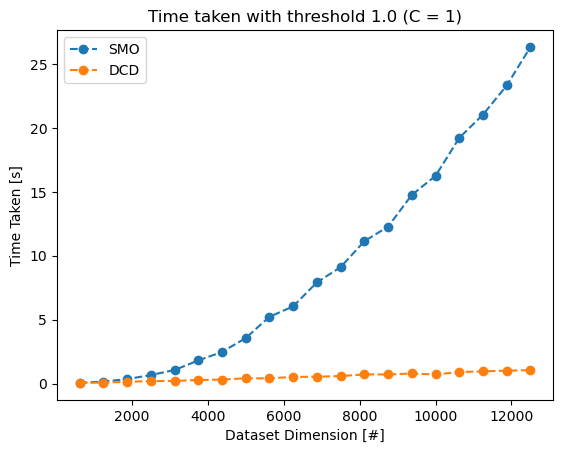

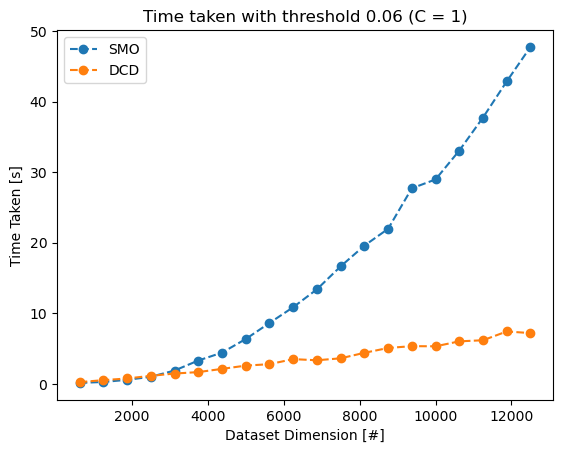

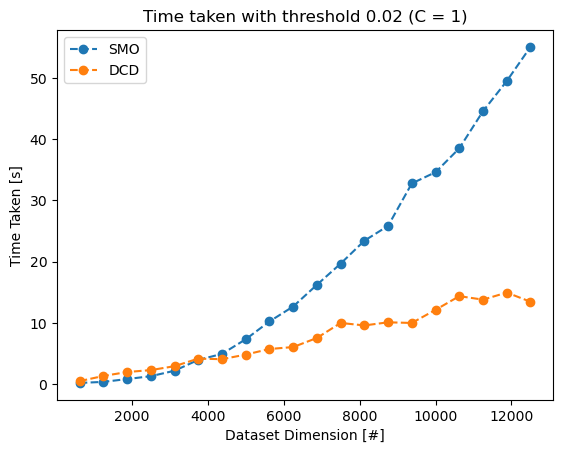

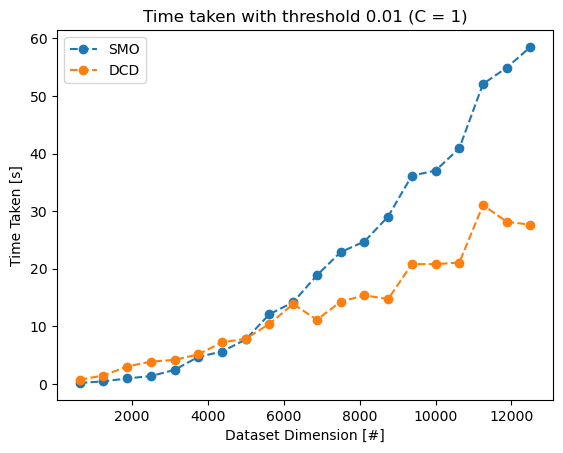

In [78]:
def plot_over_dimension(dimensions, C, index, save_fig = None):

    fig, ax = plt.subplots()
    smo_dimensions = []
    smo_times = []
    
    dcd_dimensions = []
    dcd_times = []
    
    for d in dimensions:
        smo_file = open(f"Results/smo_{d}_{C}.json", "r")
        smo_results = json.loads(smo_file.read())
        smo_times.append(smo_results["times"][index])
        smo_file.close()
        
        dcd_file = open(f"Results/dcd_{d}_{C}.json", "r")
        dcd_results = json.loads(dcd_file.read())
        dcd_times.append(dcd_results["times"][index])
        dcd_file.close()
    
    plt.plot(dimensions, smo_times, label = "SMO", marker='o', linestyle='dashed')
    plt.plot(dimensions, dcd_times, label = "DCD", marker='o', linestyle='dashed')
    
    plt.xlabel("Dataset Dimension [#]")
    plt.ylabel("Time Taken [s]")
    plt.title(f"Time taken with threshold {round(smo_results["thresholds"][index], 2)} (C = {C})")
    
    plt.legend()

    if save_fig is not None:
        if not os.path.exists("Plots"):
            os.mkdir("Plots")
    
        plt.savefig(f"Plots/{save_fig}")

    plt.show()
plot_over_dimension(dimensions, 1, 0, save_fig = "dimension_1.png")
plot_over_dimension(dimensions, 1, 3, save_fig = "dimension_2.png")
plot_over_dimension(dimensions, 1, 6, save_fig = "dimension_3.png")
plot_over_dimension(dimensions, 1, 9, save_fig = "dimension_4.png")

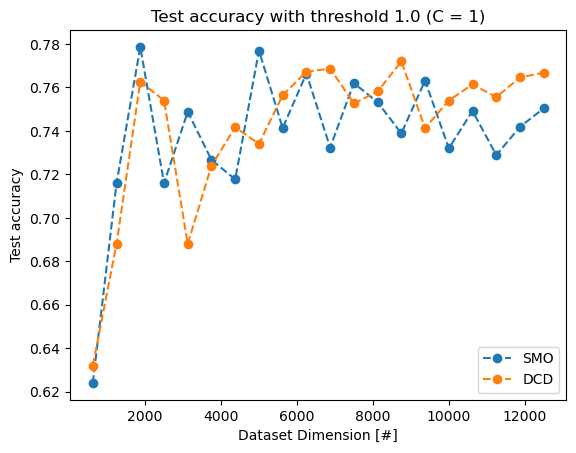

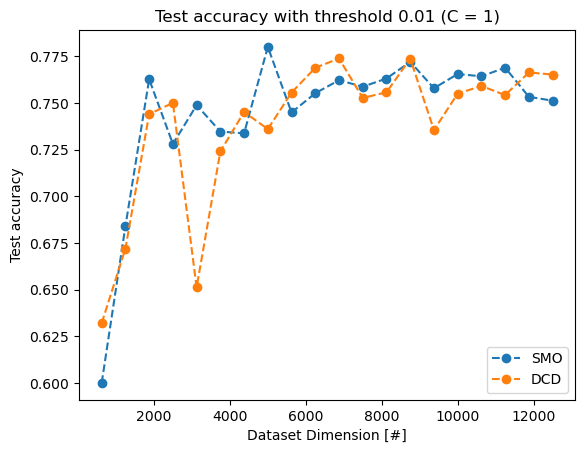

In [92]:
def plot_over_dimension_accuracy(dimensions, C, index, save_fig = None, train = False):

    fig, ax = plt.subplots()
    smo_dimensions = []
    smo_acc = []
    
    dcd_dimensions = []
    dcd_acc = []
    
    for d in dimensions:
        smo_file = open(f"Results/smo_{d}_{C}.json", "r")
        smo_results = json.loads(smo_file.read())
        if train:
            smo_acc.append(smo_results["train_accuracy"][index])
        else:
            smo_acc.append(smo_results["test_accuracy"][index])
            
        smo_file.close()
        
        dcd_file = open(f"Results/dcd_{d}_{C}.json", "r")
        dcd_results = json.loads(dcd_file.read())
        if train:
            dcd_acc.append(dcd_results["train_accuracy"][index])
        else:
            dcd_acc.append(dcd_results["test_accuracy"][index])
        dcd_file.close()
        
    plt.plot(dimensions, smo_acc, label = "SMO", marker='o', linestyle='dashed')
    plt.plot(dimensions, dcd_acc, label = "DCD", marker='o', linestyle='dashed')
    
    plt.xlabel("Dataset Dimension [#]")
    if train:
        plt.ylabel("Train accuracy")
        plt.title(f"Train accuracy with threshold {round(smo_results["thresholds"][index], 2)} (C = {C})")
    else:
        plt.ylabel("Test accuracy")
        plt.title(f"Test accuracy with threshold {round(smo_results["thresholds"][index], 2)} (C = {C})")
    
    plt.legend()

    if save_fig is not None:
        if not os.path.exists("Plots"):
            os.mkdir("Plots")
    
        plt.savefig(f"Plots/{save_fig}")
    plt.show()
plot_over_dimension_accuracy(dimensions, 1, 0, save_fig = "accuracy_dimension_1.png")
plot_over_dimension_accuracy(dimensions, 1, 9, save_fig = "accuracy_dimension_2.png")

## Results Over Threshold

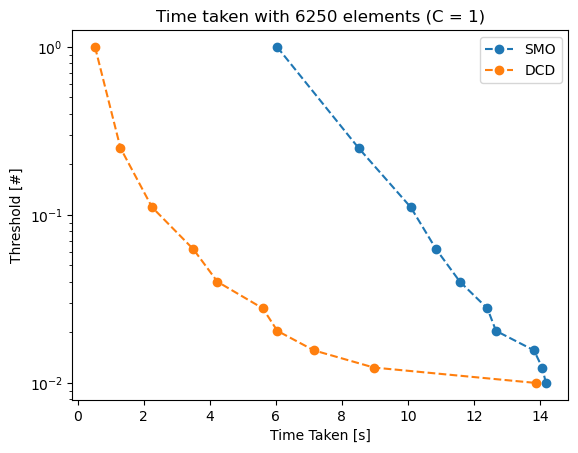

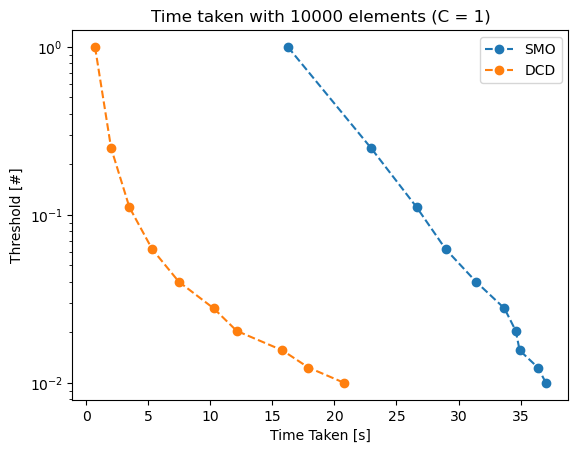

In [75]:
def plot_over_threshold(dimension, C, save_fig = None):
    fig, ax = plt.subplots()
    
    smo_file = open(f"Results/smo_{dimension}_{C}.json", "r")
    smo_results = json.loads(smo_file.read())
    smo_file.close()
    
    dcd_file = open(f"Results/dcd_{dimension}_{C}.json", "r")
    dcd_results = json.loads(dcd_file.read())
    dcd_file.close()
    
    plt.plot(smo_results["times"], smo_results["thresholds"], label = "SMO", marker='o', linestyle='dashed')
    plt.plot(dcd_results["times"], dcd_results["thresholds"], label = "DCD", marker='o', linestyle='dashed')
    
    plt.ylabel("Threshold [#]")
    plt.xlabel("Time Taken [s]")
    plt.title(f"Time taken with {dimension} elements (C = {C})")
    
    ax.set_yscale("log")
    
    plt.legend()

    if save_fig is not None:
        if not os.path.exists("Plots"):
            os.mkdir("Plots")
    
        plt.savefig(f"Plots/{save_fig}")

plot_over_threshold(6250, 1, save_fig = "threshold_1.png")
plot_over_threshold(10000, 1, save_fig = "threshold_2.png")

## Plot of accuracy related to the threshold

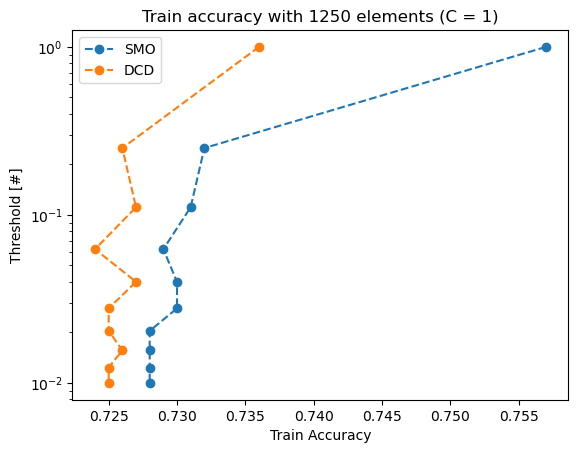

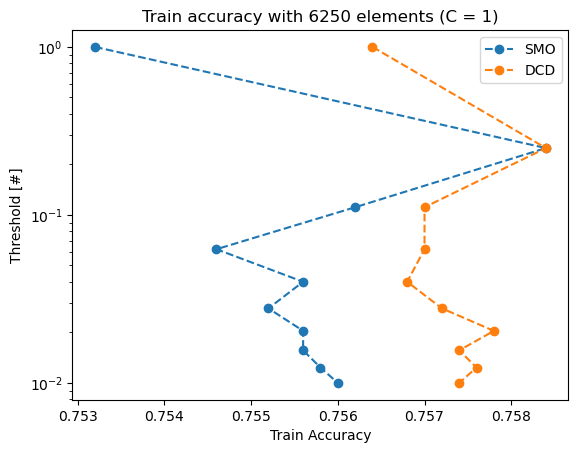

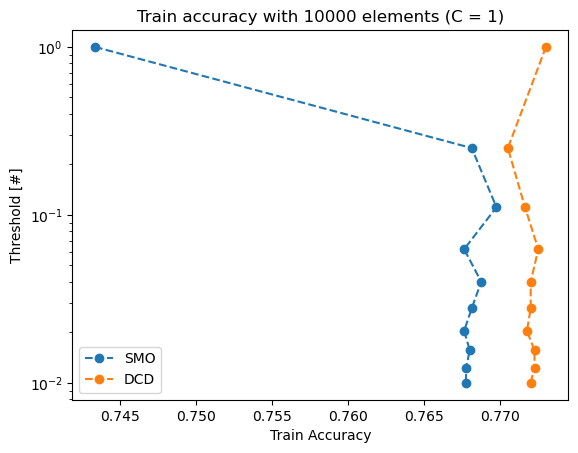

In [84]:
def plot_over_accuracy(dimension, C, save_fig = None, train = False):
    fig, ax = plt.subplots()
    
    smo_file = open(f"Results/smo_{dimension}_{C}.json", "r")
    smo_results = json.loads(smo_file.read())
    smo_file.close()
    
    dcd_file = open(f"Results/dcd_{dimension}_{C}.json", "r")
    dcd_results = json.loads(dcd_file.read())
    dcd_file.close()

    if train:
        plt.plot(smo_results["train_accuracy"], smo_results["thresholds"], label = "SMO", marker='o', linestyle='dashed')
        plt.plot(dcd_results["train_accuracy"], dcd_results["thresholds"], label = "DCD", marker='o', linestyle='dashed')
    else:
        plt.plot(smo_results["test_accuracy"], smo_results["thresholds"], label = "SMO", marker='o', linestyle='dashed')
        plt.plot(dcd_results["test_accuracy"], dcd_results["thresholds"], label = "DCD", marker='o', linestyle='dashed')
    
    plt.ylabel("Threshold [#]")
    if train:
        plt.xlabel("Train Accuracy")
        plt.title(f"Train accuracy with {dimension} elements (C = {C})")
    else:
        plt.xlabel("Test Accuracy")
        plt.title(f"Test accuracy with {dimension} elements (C = {C})")
    
    ax.set_yscale("log")
    
    plt.legend()

    if save_fig is not None:
        if not os.path.exists("Plots"):
            os.mkdir("Plots")
        plt.savefig(f"Plots/{save_fig}")
            
plot_over_accuracy(1250, 1, save_fig = "accuracy_extra.png", train = True)
plot_over_accuracy(6250, 1, save_fig = "accuracy_1.png", train = True)
plot_over_accuracy(10000, 1, save_fig = "accuracy_2.png", train = True)

## Changing Feature Number

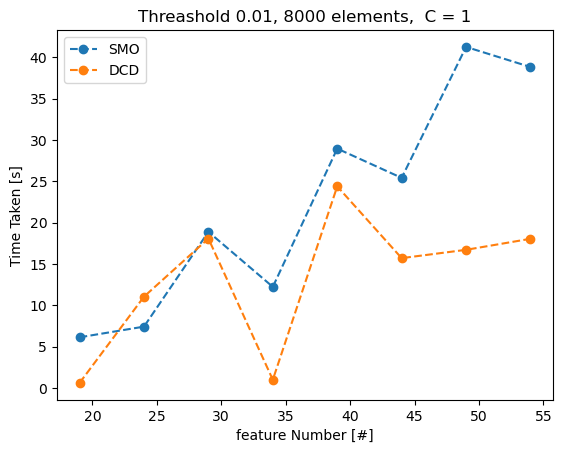

In [ ]:
def plot_over_feature(dimension, C, save_fig = None):
    fig, ax = plt.subplots()
    
    smo_file = open(f"Results/smo_features_{dimension}_{C}.json", "r")
    smo_results = json.loads(smo_file.read())
    smo_file.close()
    
    dcd_file = open(f"Results/dcd_features_{dimension}_{C}.json", "r")
    dcd_results = json.loads(dcd_file.read())
    dcd_file.close()
    
    plt.plot(smo_results["features"], smo_results["times"], label = "SMO", marker='o', linestyle='dashed')
    plt.plot(dcd_results["features"], dcd_results["times"], label = "DCD", marker='o', linestyle='dashed')
    
    plt.xlabel("feature Number [#]")
    plt.ylabel("Time Taken [s]")
    plt.title(f"Threashold {smo_results["thresholds"]}, {smo_results["dimension"]} elements,  C = {C}")
    
    plt.legend()
    if save_fig is not None:
        if not os.path.exists("Plots"):
            os.mkdir("Plots")
    
        plt.savefig(f"Plots/{save_fig}")
    plt.show()
    
plot_over_feature(10000, 1, save_fig = "features_1.png")